In [1]:
import pandas as pd
import geopandas as gpd
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from glob import glob

## GET RATE OF MISSED DETECTION / FALSE ALARMS

In [2]:
os.chdir('/exports/csce/datastore/geos/users/s1332488/chapter2_data/')

In [217]:
shadows = [gpd.read_file(f) for f in glob('shadows_aoi/poly_*.shp')]
params = [x.split('poly_')[1].split('.shp')[0] for x in glob('shadows_aoi/poly_*.shp')]
gaps = gpd.read_file('uav_canopy_gaps_over100m2.shp').to_crs('EPSG:32633')
A,B = 500,1000 # Cutoffs in m2 for small/medium/large canopy gaps
aoi = gpd.read_file('test_area_split_1ha.shp')
core_gaps = gpd.read_file('uav_gaps_CORE.shp').to_crs('EPSG:32633')
radd = gpd.read_file('shadows_aoi/poly_RADD_extended.zip').to_crs('EPSG:32633')
rndm = gpd.read_file('random_shadows/2pixel_blocks.shp').to_crs('EPSG:32633')
rndm_big = gpd.read_file('random_shadows/759l_blocks.shp').to_crs('EPSG:32633')

In [93]:
params

['N30_M9',
 'N25_M1',
 'N15_M9',
 'RADD',
 'N05_M9',
 'N30_M1',
 'N10_M1',
 'N25_M9',
 'N15_M1',
 'N05_M1',
 'N10_M9']

In [102]:
## Manual classification of N25, M0 shadows - it gives the following false alarm rate
S = shadows[1]
100* (1-S[S.IS_GAP==1].area.sum() / S.area.sum())
# Which turns out to be exactly the same as taking the original intersection method


6.181409829735928

In [167]:
thresh = 0.001 # Fractional area of intersection for a polygon to count as correct

def get_acc_n(df,col):
    return df[col].mean()
# USING AREA BASED METRICS - AS AREA DEGRADED IS THE MAIN AIM

def get_acc_area(df,col):
    if df.area.sum() != 0 :
        return df[df[col]].area.sum() / df.area.sum()
    else:
        return np.nan

def get_acc(df,col):
    small,medium,large = df[df.area<=A] , df[(df.area>A) & (df.area<=B)] , df[df.area>B]
    return np.array([get_acc_area(df,col),
                     get_acc_area(small,col),
                     get_acc_area(medium,col),
                     get_acc_area(large,col)])
#     return np.array([get_acc_n(df,col),
#                      get_acc_n(small,col),
#                      get_acc_n(medium,col),
#                      get_acc_n(large,col)])

def overall_acc(S,G):
    total_area = aoi.area.sum()
    false_alarm = S[~S.shadow_is_gap].area.sum()
    missed_detection = G[~G.gap_detected].area.sum()
    return (total_area - false_alarm - missed_detection) / total_area

def get_stats(S,p): # S being shadow dataset and p being the parameter string
    G = gaps.copy()
    S['shadow_is_gap'] = (S.intersection(G.unary_union).area / S.area) > thresh
    G['gap_detected'] = (G.intersection(S.unary_union).area / G.area) > thresh
    false_alarm = 100* (1-get_acc(S,'shadow_is_gap'))
    missed_detection = 100* (1-get_acc(G,'gap_detected'))
    overall = np.array([overall_acc(S,G)])
    data = np.concatenate([overall,false_alarm,missed_detection])
    return pd.DataFrame([data],
                        columns=['Overall',
                                 'FA_total','FA_small','FA_medium','FA_big',
                                 'MD_total','MD_small','MD_medium','MD_big'],
                        index=[p])

In [40]:
get_stats(radd,'radd to 2021')

/home/s1332488/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


,Overall,FA_total,FA_small,FA_medium,FA_big,MD_total,MD_small,MD_medium,MD_big
radd to 2021,0.953447,7.623311,NaN,0.0,7.94392,88.519875,98.767023,100.0,70.310857


In [153]:
stats = get_stats(shadows[0],params[0])
for i in range(1,len(params)):
    stats=stats.append(get_stats(shadows[i],params[i]))

In [154]:
stats['Overall'] = 100*stats.Overall

In [155]:
stats.sort_values(by='Overall',ascending=False).round(1)

,Overall,FA_total,FA_small,FA_medium,FA_big,MD_total,MD_small,MD_medium,MD_big
N25_M1,99.0,6.6,31.1,5.5,0.0,12.1,35.1,9.8,0.0
N25_M9,98.8,4.2,30.3,10.6,0.0,17.0,48.3,14.3,0.0
N30_M9,98.8,5.9,38.5,18.0,0.0,14.6,40.3,13.0,0.0
N30_M1,98.7,10.2,45.1,5.9,0.0,11.6,33.5,9.4,0.0
N15_M9,98.6,6.7,37.6,9.7,0.0,20.6,54.7,19.7,0.0
N15_M1,98.4,14.8,53.3,6.1,0.0,13.1,37.5,9.1,1.8
N10_M9,98.3,8.7,30.8,14.6,0.0,25.0,57.6,29.3,0.0
N10_M1,98.3,16.6,46.7,6.2,0.0,17.5,45.9,12.2,5.1
N05_M9,97.6,12.6,33.8,10.2,0.0,40.1,73.4,48.4,10.4
N05_M1,97.4,28.2,52.6,9.7,0.0,26.3,55.7,26.7,7.4


## Random Analysis

In [225]:
### USING MEAN AREA OF SHADOW BLOCKS....

print('Number of 759m2 boxes to fil for a random shadow distribution')
print(gaps.area.sum()/759)

p = 212/4122 # Probability of each box being a shadow

accs_big = []
fas_big = []
mds_big = []
for i in range(1000):
    R = rndm_big.copy()
    R['shadow']= np.random.choice([0,1], size=4122, replace=True, p=[1-p,p])
    R = R[R.shadow==1]
    STATS = get_stats(R,'')
    accs_big.append(STATS.Overall[0])
    fas_big.append(STATS.FA_total[0])
    mds_big.append(STATS.MD_total[0])

Number of 759m2 boxes to fil for a random shadow distribution
212.41482595167352


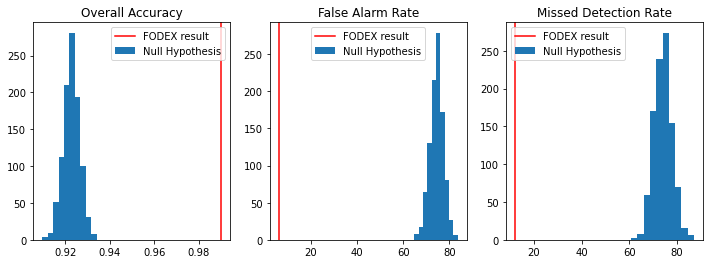

ACCURACY
0.9227356542098076 0.003683474775384656
FALSE ALARM
74.55630157184981 2.944891178928594
MISSED DETECTION
74.16129150311524 3.79639333011473


In [226]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Overall Accuracy')
plt.hist(accs_big,label='Null Hypothesis')
plt.axvline(x=0.99,color='red',label='FODEX result')
plt.legend()

plt.subplot(1,3,2)
plt.title('False Alarm Rate')
plt.hist(fas_big,label='Null Hypothesis')
plt.axvline(x=6,color='red',label='FODEX result')
plt.legend()

plt.subplot(1,3,3)
plt.title('Missed Detection Rate')
plt.hist(mds_big,label='Null Hypothesis')
plt.axvline(x=12,color='red',label='FODEX result')
plt.legend()
plt.savefig('/home/s1332488/chapter2/reviews/null_hyp_big.png',dpi=300)
plt.show()


print('ACCURACY')
print(np.array(accs_big).mean(),np.array(accs_big).std())
print('FALSE ALARM')
print(np.array(fas_big).mean(),np.array(fas_big).std())
print('MISSED DETECTION')
print(np.array(mds_big).mean(),np.array(mds_big).std())

In [168]:
### USING 200m2 BLOCKS

print('Number of 200m2 boxes to fill for a random shadow distribution')
print(gaps.area.sum() / 200)
####################
p = 806/15636 
## Probability of each box being a shadow

accs = []
fas = []
mds = []
for i in range(1000):
    R = rndm.copy()
    R['shadow']= np.random.choice([0,1], size=15636, replace=True, p=[1-p,p])
    R = R[R.shadow==1]
    STATS = get_stats(R,'')
    accs.append(STATS.Overall[0])
    fas.append(STATS.FA_total[0])
    mds.append(STATS.MD_total[0])

# plt.figure(figsize=(12,12))
# ax = plt.axes()
# test.plot(ax=ax,alpha=0.5)
# gaps.plot(ax=ax,color='red',alpha=0.5)


Number of 200m2 boxes to fill for a random shadow distribution
806.114264486601


In [184]:
accs = [x[0] for x in accs]
fas = [x[0] for x in fas]
mds = [x[0] for x in mds]

In [216]:
shadows[1].area.mean()

759.3122303306282

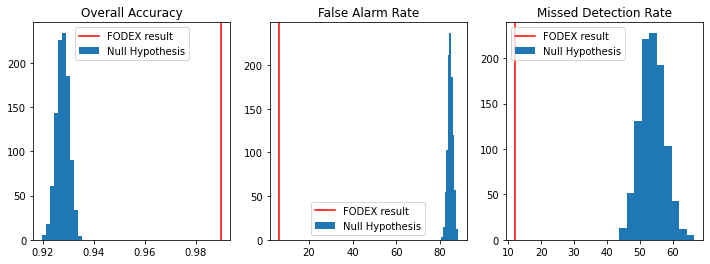

ACCURACY
0.9279916518840802 0.002497162315912617
FALSE ALARM
84.85729970866299 1.238188438059536
MISSED DETECTION
53.77662686279818 3.686369016416197


In [215]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Overall Accuracy')
plt.hist(accs,label='Null Hypothesis')
plt.axvline(x=0.99,color='red',label='FODEX result')
plt.legend()

plt.subplot(1,3,2)
plt.title('False Alarm Rate')
plt.hist(fas,label='Null Hypothesis')
plt.axvline(x=6,color='red',label='FODEX result')
plt.legend()

plt.subplot(1,3,3)
plt.title('Missed Detection Rate')
plt.hist(mds,label='Null Hypothesis')
plt.axvline(x=12,color='red',label='FODEX result')
plt.legend()
plt.savefig('/home/s1332488/chapter2/reviews/null_hyp.png',dpi=300)
plt.show()


print('ACCURACY')
print(np.array(accs).mean(),np.array(accs).std())
print('FALSE ALARM')
print(np.array(fas).mean(),np.array(fas).std())
print('MISSED DETECTION')
print(np.array(mds).mean(),np.array(mds).std())

(0.0, 50.0)

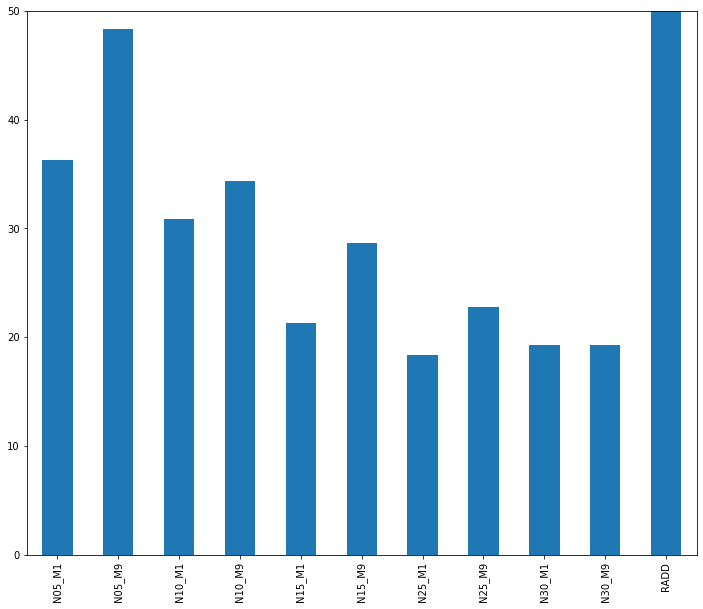

In [91]:
plt.figure(figsize=(12,10))
ax=plt.axes()
# stats.sort_index().Overall.plot.bar(ax=ax)
# plt.ylim(95,99)
stats.sort_index().MD_medium.plot.bar(ax=ax)
plt.ylim(0,50)

In [15]:
print('total area of canopy gaps: ',str(round(gaps.area.sum()/10000,2)),' ha')
print('total AOI: ',str(round(aoi.area.sum()/10000,2)),' ha')
print('Overall percentage canopy gaps: ',str(round(100*gaps.area.sum()/aoi.area.sum(),2)),' %')


total area of canopy gaps:  16.13  ha
total AOI:  310.4  ha
Overall percentage canopy gaps:  5.2  %


In [87]:
shad = shadows[0]
small = shad[shad.area<=A]
area_small = small.area.sum()
print('Area of Small Shadows: ',str(round(area_small/10000,2)))

Area of Small Shadows:  3.2


In [183]:
stats.round(1).to_csv('N_images_ML_stats.csv')

In [139]:
#### Now check out the correlation coefficients

In [4]:
glob('one_hectare_corr/*.csv')

['one_hectare_corr/shadows_N05_M9.csv',
 'one_hectare_corr/shadows_N05_M1.csv',
 'one_hectare_corr/shadows_N30_M9.csv',
 'one_hectare_corr/shadows_RADD.csv',
 'one_hectare_corr/shadows_N30_M1.csv',
 'one_hectare_corr/shadows_N15_M1.csv',
 'one_hectare_corr/shadows_N10_M1.csv',
 'one_hectare_corr/shadows_N15_M9.csv',
 'one_hectare_corr/shadows_N10_M9.csv',
 'one_hectare_corr/shadows_N25_M9.csv',
 'one_hectare_corr/shadows_N25_M1.csv']

In [5]:
files= glob('one_hectare_corr/*.csv')
files.sort()
corr = [pd.read_csv(f) for f in files]
p = [x.split('shadows_')[1].split('.csv')[0] for x in files]

['N05_M1', 'N05_M9', 'N10_M1', 'N10_M9', 'N15_M1', 'N15_M9', 'N25_M1', 'N25_M9', 'N30_M1', 'N30_M9', 'RADD']
N25_M1
canopy disturbance = 0.8748421110439895 x S-1 (total area fit)
[1.07208023]


/home/s1332488/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


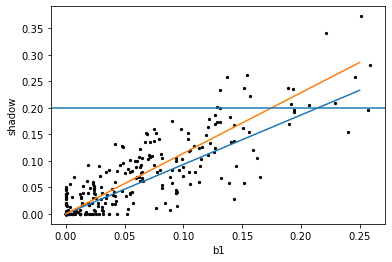

In [7]:
print(p)
print(p[-5])
data = corr[-5]
SLOPE = data.b1.sum() / data.shadow.sum()
print('canopy disturbance = '+str(SLOPE)+' x S-1 (total area fit)')
x = data.b1.values[:,np.newaxis]
slope2, _, _, _ = np.linalg.lstsq(x, data.shadow)
# slope2 = np.polyfit(data.b1,data.shadow,1)
print(slope2)
data.plot.scatter(x='b1',y='shadow',color='black',s=5)
plt.plot( np.linspace(0,0.25),np.linspace(0,0.25)/slope2)
plt.plot( np.linspace(0,0.25),np.linspace(0,0.25)/SLOPE)
plt.axhline(y=0.2)

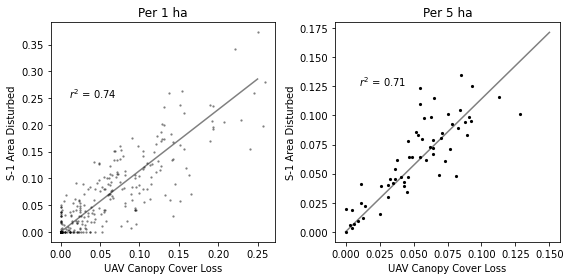

In [10]:
N25 = corr[-5]
corr_5ha = pd.read_csv('correlation_5ha.csv')
plt.figure(figsize=(8,4))
plt.subplot(1,2,2)
plt.title('Per 5 ha')
plt.xlabel('UAV Canopy Cover Loss')
plt.ylabel('S-1 Area Disturbed')
xx = np.linspace(0,0.15)
R =corr_5ha.corr().shadow.b1
plt.text(0.01,0.125,'$r^2$ = '+str(round(R**2,2)))
plt.plot(xx,xx/SLOPE,color='grey',zorder=0)
plt.scatter(corr_5ha.b1,corr_5ha.shadow,color='black',s=10,alpha=1,linewidths=0)
plt.subplot(1,2,1)
plt.title('Per 1 ha')
plt.xlabel('UAV Canopy Cover Loss')
plt.ylabel('S-1 Area Disturbed')
xx = np.linspace(0,0.25)
plt.plot(xx,xx/SLOPE,color='grey',zorder=0)
R =N25.corr().shadow.b1
plt.scatter(N25.b1,N25.shadow,color='black',s=5,alpha=0.5,linewidths=0)
plt.text(0.01,0.25,'$r^2$ = '+str(round(R**2,2)))
plt.tight_layout()
plt.savefig('/home/s1332488/chapter2/correlation_1ha5ha.png',dpi=300)

In [11]:
print(1/SLOPE)

1.143063402385436


In [12]:
def rmse(data):
    slope = data.shadow.sum()/data.b1.sum()
    data['estimated'] = data.shadow/slope
    err = np.sqrt(((data.estimated - data.b1) ** 2).mean())
    return err

In [13]:
p

['N05_M1',
 'N05_M9',
 'N10_M1',
 'N10_M9',
 'N15_M1',
 'N15_M9',
 'N25_M1',
 'N25_M9',
 'N30_M1',
 'N30_M9',
 'RADD']

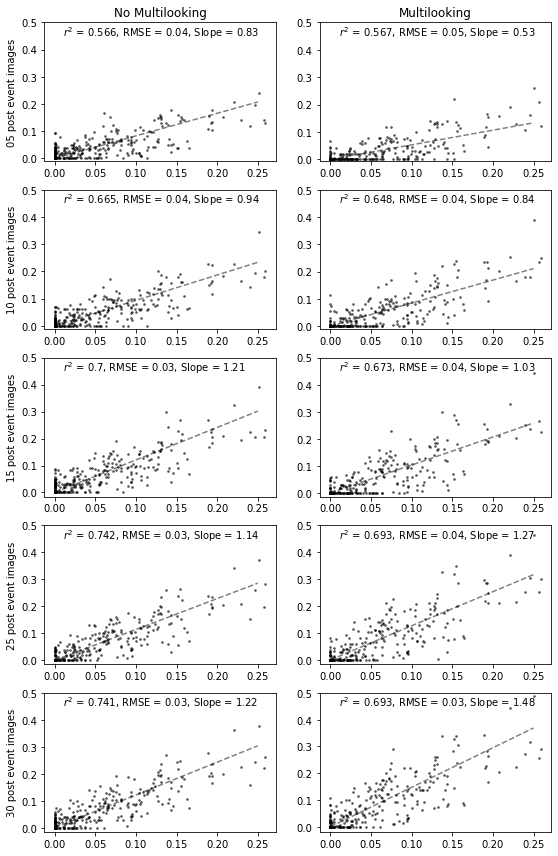

In [15]:
plt.figure(figsize=(8,12))
for i in range(10):
    data = corr[i]
    N = p[i][1:3]
    M=(p[i][-1])
    slope = data.shadow.sum() / data.b1.sum()
    err = rmse(data)
    plt.subplot(5,2,i+1)
    if i ==0:
       plt.title('No Multilooking')
    if i == 1:
       plt.title('Multilooking')
    if i%2==0:
       plt.ylabel(N+' post event images')
    R = corr[i].corr().shadow.b1
    plt.text(0.01,0.45,'$r^2$ = '+str(round(R**2,3))+', RMSE = '+str(round(err,2))+', Slope = '+str(round(slope,2)))
    xx = np.linspace(0,0.25)
    plt.plot(xx,slope*xx,color='black',ls='--',alpha=0.5)
    plt.ylim(None,0.5)
    plt.scatter(data.b1,data.shadow,color='black',s=3,alpha=0.5)
plt.tight_layout()
plt.savefig('/home/s1332488/chapter2/N_ML_comparison.png',dpi=300)
plt.show()


In [52]:
df_dates = shadows[0]
df_dates['shadow_is_gap'] = df_dates.intersects(gaps.unary_union)
df_dates['is_core'] = df_dates.intersects(core_gaps.unary_union)
df_dates.head()

,DN,id,geometry,shadow_is_gap,is_core
0,1,None,"POLYGON ((195350.000 -15039.878, 195350.000 -1...",True,False
1,1,None,"POLYGON ((195400.000 -15010.000, 195430.000 -1...",True,False
2,1,None,"POLYGON ((195590.000 -15030.000, 195620.000 -1...",True,False
3,1,None,"POLYGON ((195470.000 -15050.000, 195490.000 -1...",True,False
4,1,None,"POLYGON ((195300.000 -15140.000, 195320.000 -1...",True,False


In [31]:
360/12

30.0

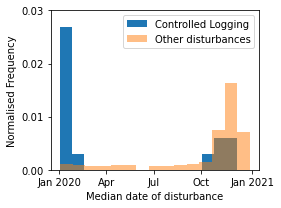

In [36]:
# Compare true shadows to false alarms
# df_dates[df_dates.shadow_is_gap].date_media.plot.hist(bins=25)
# df_dates[~df_dates.shadow_is_gap].date_media.plot.hist(alpha=0.5,bins=25)

# Plot overall histogram
plt.figure(figsize=(4,3))
df_dates[df_dates.is_core]._median.plot.hist(density=True,label='Controlled Logging',bins=15)
df_dates[~df_dates.is_core]._median.plot.hist(density=True,label='Other disturbances',alpha=0.5,bins=15)
plt.legend()
plt.xticks([15,105,195,285,(366+15)],['Jan 2020','Apr','Jul','Oct','Jan 2021'])
plt.yticks([0,0.01,0.02,0.03])
plt.ylabel('Normalised Frequency')
plt.xlabel('Median date of disturbance')
plt.tight_layout()
plt.savefig('/home/s1332488/chapter2/shadow_dates_aoi.png',dpi=300)

In [53]:
gaps['gap_detected'] = gaps.intersects(df_dates.unary_union)
gaps

,id,area,perimeter,geometry,gap_detected
0,None,1016.570587,181.028671,"POLYGON ((195394.102 -15028.186, 195394.100 -1...",True
1,None,1352.351257,183.042691,"POLYGON ((195456.906 -15072.128, 195461.391 -1...",True
2,None,992.241898,194.673357,"POLYGON ((195416.539 -15110.815, 195425.305 -1...",True
3,None,272.929825,93.235663,"POLYGON ((195355.165 -15082.114, 195360.057 -1...",False
4,None,192.878143,55.881906,"POLYGON ((195344.558 -15046.673, 195349.043 -1...",True
...,...,...,...,...,...
260,None,106.990906,68.279015,"POLYGON ((195347.040 -16081.098, 195352.249 -1...",False
261,None,NaN,NaN,"POLYGON ((193913.580 -16223.898, 193915.364 -1...",False
262,None,NaN,NaN,"POLYGON ((195945.144 -15413.407, 195947.273 -1...",True
263,None,NaN,NaN,"POLYGON ((196963.069 -15478.145, 196969.789 -1...",False


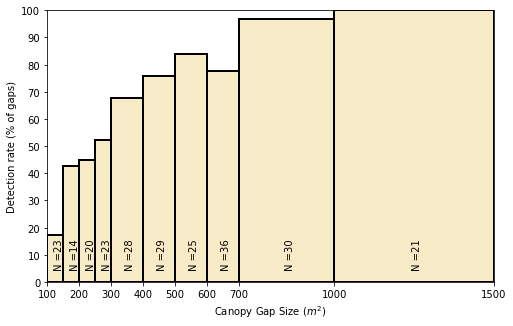

In [61]:
plt.figure(figsize=(8,5))
edges = [100,150,200,250,300,400,500,600,700,1000,1500]
mids = (np.array(edges)[:-1] + np.array(edges)[1:])/2
widths = (np.array(edges)[:-1] - np.array(edges)[1:])
cut = pd.cut(gaps.area,edges)
success= gaps.groupby(cut).mean().gap_detected
N = gaps.groupby(cut).size()
plt.bar(mids,success,width=widths,color='#f7eac6',edgecolor='black',lw=2)
i=0
for x in N:
    plt.text(mids[i]-5,0.05,'N ='+str(x),rotation=90)
    i+=1
plt.xticks([100,200,300,400,500,600,700,1000,1500])
plt.xlabel('Canopy Gap Size ($m^2$)')
plt.yticks(np.arange(0,1.1,0.1),np.arange(0,101,10))
plt.ylim(0,1)
plt.xlim(100,1500)
plt.ylabel('Detection rate (% of gaps)')
plt.savefig('/home/s1332488/chapter2/detection_rate.png',dpi=300)
plt.show()

In [122]:
gaps.groupby(cut).size()

(100, 175]      30
(175, 250]      27
(250, 325]      32
(325, 400]      19
(400, 500]      29
(500, 600]      25
(600, 700]      36
(700, 800]      15
(800, 900]       8
(900, 1000]      7
(1000, 1500]    21
dtype: int64

In [4]:
stats = pd.read_csv('stats_for_graph.csv')
stats=stats.sort_values(by='N')

AttributeError: 'DataFrame' object has no attribute 'ML'

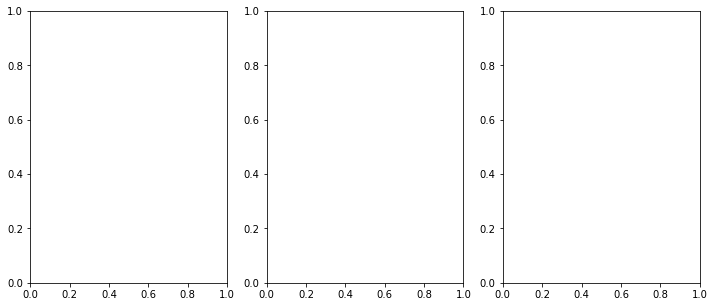

In [45]:
fig,axs = plt.subplots(1,3,figsize=(12,5))

WIDTH = 0.25
def do_subplot(yfeature):
    stats[stats.ML==1].plot.bar(x='N',y=yfeature,ax=ax,label='Multilooking',
                                color='grey',align='edge',width=WIDTH)
    stats[stats.ML==0].plot.bar(x='N',y=yfeature,ax=ax,label='No Multilooking',
                                color='black',align='edge',width=-WIDTH)
ax = axs[0]
do_subplot('Overall')
ax.set(ylim=(97.1,99.1),xlim=(-1,5))
ax.set(title='Overall Accuracy (%)')
ax = axs[1]
do_subplot('FA_total')
ax.set(xlim=(-1,5))
# stats[stats.ML==1].plot(x='N',y='FA_total',ax=ax,marker='o',color='#006837',
#                         label='Multilooking',lw=0)
# stats[stats.ML==0].plot(x='N',y='FA_total',ax=ax,marker='s',color='black',
#                         label='No Multilooking',lw=0)
ax.legend()
ax.set(title='False Alarm Rate (%)')
ax = axs[2]
do_subplot('MD_total')
ax.set(xlim=(-1,5))
# stats[stats.ML==1].plot(x='N',y='MD_total',ax=ax,marker='o',color='#006837',
#                         label='Multilooking',lw=0)
# stats[stats.ML==0].plot(x='N',y='MD_total',ax=ax,marker='s',color='black',
#                         label='No Multilooking',lw=0)
ax.set(title='Missed Detection Rate (%)')
ax.legend()

for ax in axs:
    ax.set(xlabel='n (post-event images)')
    
plt.savefig('/home/s1332488/chapter2/accuracy_v2.png',dpi=300)